In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
from skimage.segmentation import slic

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.segmentation2 as segment2

importlib.reload(segment)
importlib.reload(segment2)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
file_names.extend(['tnr_12702_dtm.tif'])
file_names.extend(['Tnr_12702_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_12702_D-20210713_DSM.tif
Width[px]: 4749
Height[px]: 4626
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661774.3636313608, bottom=5470426.000381344, right=662196.9573473627, top=5470837.648840014)
Affine geo-transfrom: [0.08898583196501086, 0.0, 661774.3636313608, 0.0, -0.0889858319649575, 5470837.648840014]

(1)
Name: C:/Data/lwf/DTM/tnr_12702_dtm.tif
Width[px]: 398
Height[px]: 409
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661789.9361519547, bottom=5470428.936913799, right=662187.9361519547, top=5470837.936913799)
Affine geo-transfrom: [1.0, 0.0, 661789.9361519547, 0.0, -1.0, 5470837.936913799]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_12702_2021_Ortho.tif
Width[px]: 7913
Height[px]: 8617
No. of rasters: 5
  Index: 1, dtype: uint16


### Reproject raster-files to same area & resolution

In [492]:
importlib.reload(io)
res = 0.2
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

### Define and normalize channels

In [552]:
importlib.reload(io)

cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

reduce = 2
cs = io.define_channels(cs_prim, reduce=reduce)

res_final = res * 2**reduce
print(res_final)

0.8


### Global mask and local mask by adaptive gaussian thresholding


Distance set to: 25 [px]


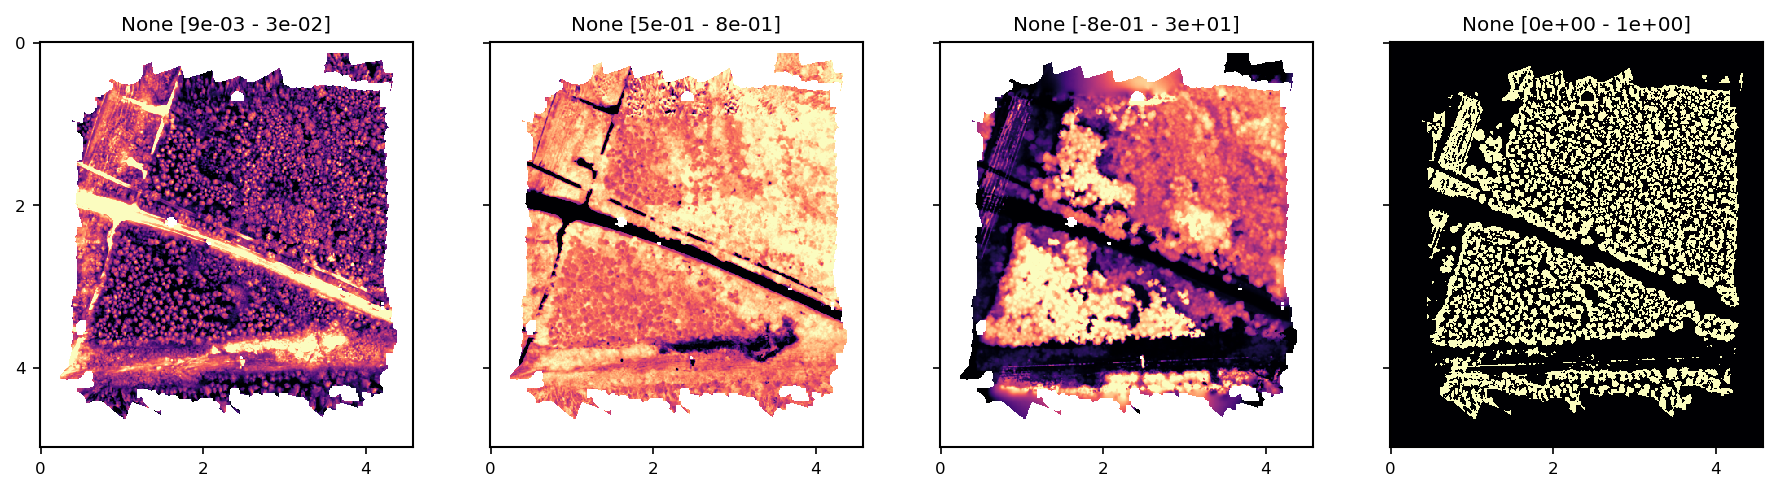

In [553]:
importlib.reload(visual)
importlib.reload(segment2)

# Rough global mask of positives
mask_global = (cs['chm'] > 3) & (cs['ndvi'] > 0.6) & (cs['l'] > 5e-3)

# Local mask of positives by adaptive thresholding
img = cs['l']
distance = 20 / res_final
mask_local = segment2.local_thresholding(img, mask_global, distance)


channels = [
    cs['l'], cs['ndvi'], cs['chm'], mask_local
]

xylim = [(190,100//2), (170,100//2)]
f, axs = visual.show_channels(
    channels,
    # xylim=xylim,
    # mask=mask_global,
    zoom=1,
)

In [554]:
importlib.reload(segment2)
ccs_idx = segment2.connectedComponents_idx(mask_local.copy())
ccs_size = np.array([len(idx[0]) for idx in ccs_idx])
ccs_large_idx = np.where(ccs_size > 100)[0]

424


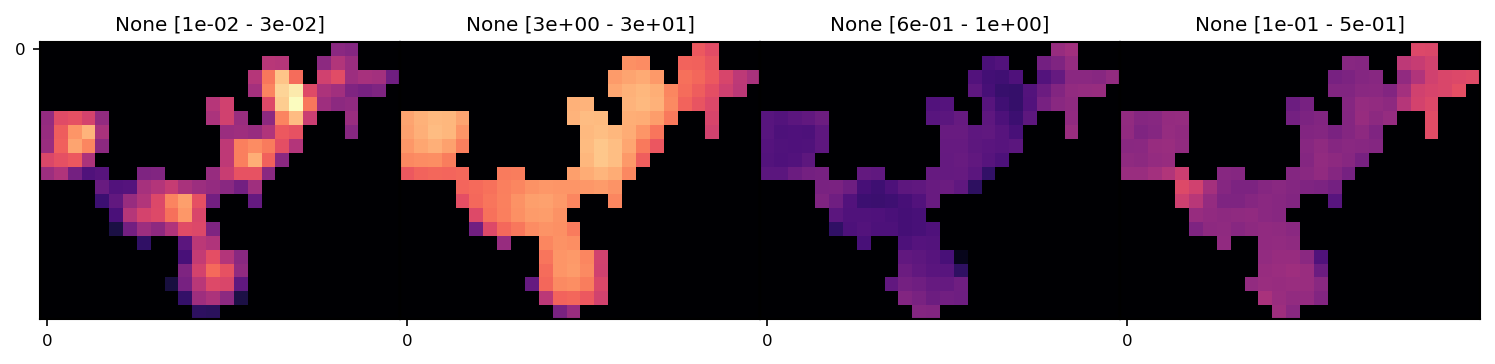

In [567]:
def connectedComponent_rclim(idx):
    rc_origin = (np.min(idx[0]), np.min(idx[1])) 
    rc_width = (
        np.max(idx[0]) - np.min(idx[0]) + 1,
        np.max(idx[1]) - np.min(idx[1]) + 1,
    ) 
    return rc_origin, rc_width

def connectedComponent_img_tobox(idx, img):
    rclim = connectedComponent_rclim(idx)

    box = np.zeros((rclim[1][0], rclim[1][1]), dtype=np.float32)
    idx_box = (
        idx[0].copy() - rclim[0][0],
        idx[1].copy() - rclim[0][1],
    )
    box[idx_box] = img[idx]

    return box

def connectedComponent_dataprep(idx, chm, colors, res_xy=0.8, res_z=1):
    
    length = len(idx[0])
    n_colors = len(colors)
    
    data = np.zeros((length, 3 + n_colors))




########################
i = ccs_large_idx[np.random.randint(0, len(ccs_large_idx))]
print(i)
idx = ccs_idx[i]

l_box = connectedComponent_img_tobox(idx, cs['l'])
chm_box = connectedComponent_img_tobox(idx, cs['chm'])
ndvi_box = connectedComponent_img_tobox(idx, cs['ndvi'])
s_box = connectedComponent_img_tobox(idx, cs['s'])

channels = [l_box, chm_box, ndvi_box, s_box]
contrasts = [(1e-2,3e-2), (3, 30), (0.6,1.05), (0.1,0.5)]

f, axs = visual.show_channels(
    channels, 
    contrasts=contrasts,
    zoom=0.8)